# **SPICED ACADEMY  //  WEEK 08  //  SUPERMARKET MARKOV SIMULATION**

**Brunno Gorgulho Soares**

# 0. Set Up

In [2]:
# Essentials
import pandas as pd
import numpy as np

# Simulating
import random
from Customer import Customer

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

# PEP8
# %load_ext pycodestyle_magic

# 1. Get Data

In [3]:
# %%pycodestyle

def get_data():

    for day in ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']:

        file = f'data/{day}.csv'
        df_temp = pd.read_csv(file, sep=';', parse_dates=['timestamp'])

        if day=='monday':
            df = df_temp
        
        else:
            df_temp['customer_no'] += last_customer        
            df = pd.concat([df, df_temp])

        last_customer = df['customer_no'].max()

    return df

In [4]:
df = get_data()

Remove customers which never make it to checkout (store closes before they do).

In [5]:
last_location = df.sort_values('timestamp').groupby('customer_no').tail(1)
excluded_customers = last_location[last_location['location']!='checkout']['customer_no']
df = df[~(df['customer_no'].isin(excluded_customers))]

Resample to have minute-by-minute observation.

In [6]:
df.set_index('timestamp', inplace=True)

In [7]:
df = df.groupby('customer_no').resample(rule='T').last().fillna(method='ffill')

In [8]:
df.index = df.index.droplevel(0)

In [9]:
df.reset_index(inplace=True)

# 2. Data Exploration

In [10]:
df[['customer_no', 'location']].groupby(['customer_no']).count().describe()

,location
count,7417.000000
mean,7.246191
std,6.003690
min,2.000000
25%,3.000000
50%,5.000000
75%,9.000000
max,53.000000


In [11]:
df.isna().sum()

timestamp      0
customer_no    0
location       0
dtype: int64

In [12]:
df.describe(datetime_is_numeric=True)

,timestamp,customer_no
count,53745,53745.000000
mean,2019-09-04 15:15:37.044934656,3710.655298
min,2019-09-02 07:03:00,1.000000
25%,2019-09-03 10:46:00,1814.000000
50%,2019-09-04 15:07:00,3710.000000
75%,2019-09-05 19:02:00,5596.000000
max,2019-09-06 21:50:00,7443.000000
std,NaN,2165.147235


Total number of customers per location, at any given point in time.

<AxesSubplot:xlabel='location'>

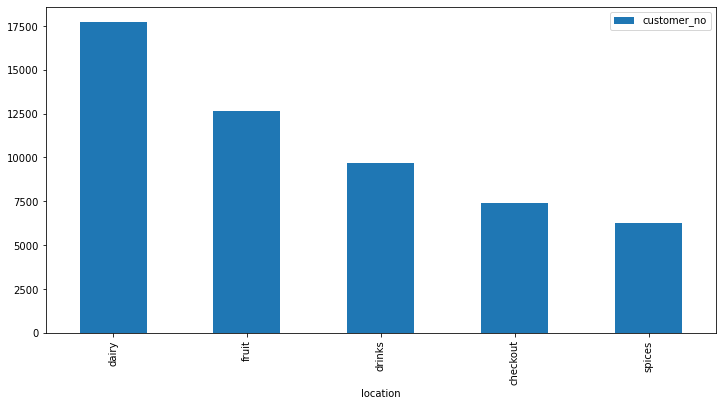

In [13]:
df[['customer_no', 'location']].groupby('location').count().sort_values(by='customer_no', ascending=False).plot.bar()

In [14]:
df['rounded_timestamp'] = df['timestamp'].round('H')
df[['location', 'rounded_timestamp', 'customer_no']].groupby(by=['rounded_timestamp', 'location']).count().unstack().fillna(0)['customer_no']

location,checkout,dairy,drinks,fruit,spices
rounded_timestamp,,,,,
2019-09-02 07:00:00,41,84,65,61,32
2019-09-02 08:00:00,102,253,160,155,71
2019-09-02 09:00:00,94,236,184,202,96
2019-09-02 10:00:00,99,238,130,179,70
2019-09-02 11:00:00,73,178,94,109,93
...,...,...,...,...,...
2019-09-06 18:00:00,128,321,180,251,108
2019-09-06 19:00:00,141,300,209,262,115
2019-09-06 20:00:00,130,290,199,243,110


<AxesSubplot:xlabel='timestamp'>

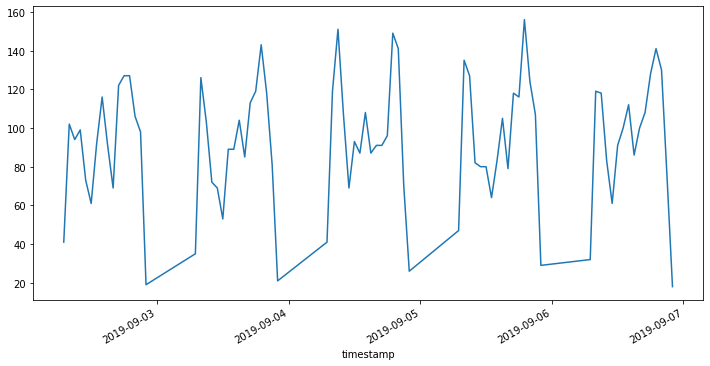

In [15]:
df[df['location']=='checkout']['customer_no'].groupby(df['timestamp'].round('H')).count().plot()

<AxesSubplot:>

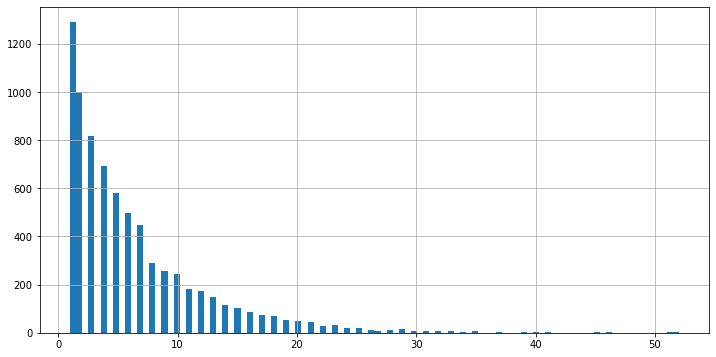

In [16]:
cust_max_time = df[['customer_no', 'timestamp']].groupby('customer_no').max()
cust_min_time = df[['customer_no', 'timestamp']].groupby('customer_no').min()
cust_len_stay = cust_min_time.join(cust_max_time, how='right', lsuffix='_min', rsuffix='_max')
cust_len_stay['length_stay'] = (cust_len_stay['timestamp_max'] - cust_len_stay['timestamp_min']).astype('timedelta64[m]')
cust_len_stay['length_stay'].hist(bins=100)

<AxesSubplot:xlabel='timestamp'>

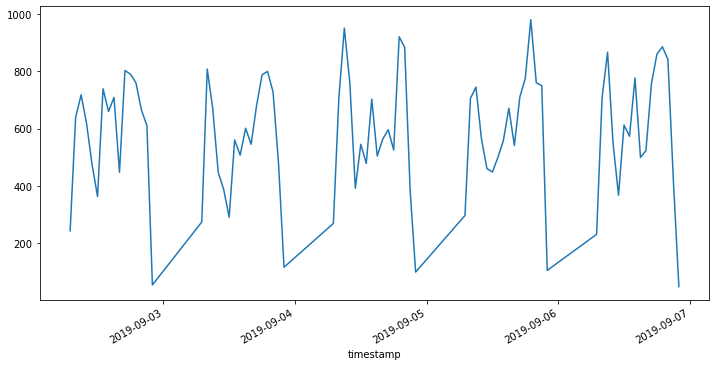

In [17]:
df[df['location']!='checkout']['customer_no'].groupby(df['timestamp'].round('H')).count().plot()

<AxesSubplot:>

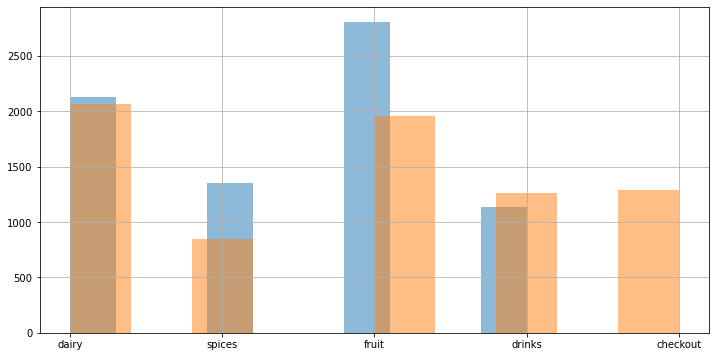

In [18]:
df['step'] = df.groupby(['customer_no']).cumcount()+1
df[df['step']==1]['location'].hist(alpha=0.5)
df[df['step']==2]['location'].hist(alpha=0.5)

In [19]:
df[df['customer_no']==6][['timestamp']].diff(1).shift(-1)
df[df['customer_no']==6][['timestamp']]

df_sorted = df.sort_values(by=['customer_no', 'timestamp'])
df_sorted['time_spent'] = df_sorted.groupby('customer_no')['timestamp'].diff(1).shift(-1)

In [20]:
time_per_loc = pd.DataFrame(df_sorted.groupby('location')['time_spent'].sum())
rev_per_min = pd.DataFrame(data=[4, 3, 5, 6], index=['fruit', 'spices', 'dairy', 'drinks'], columns=['revenue_per_minute'])
total_rev = time_per_loc.join(rev_per_min)[1:]

total_rev['time_spent_mins'] = [t.total_seconds()/60 for t in total_rev['time_spent']]
total_rev['total_revenue'] = total_rev['revenue_per_minute'] * total_rev['time_spent_mins']
total_rev.sort_values('total_revenue', ascending=False)

,time_spent,revenue_per_minute,time_spent_mins,total_revenue
location,,,,
dairy,12 days 07:24:00,5.0,17724.0,88620.0
drinks,6 days 17:27:00,6.0,9687.0,58122.0
fruit,8 days 19:03:00,4.0,12663.0,50652.0
spices,4 days 08:14:00,3.0,6254.0,18762.0


Add before_state and after_state columns

In [21]:
# pd.crosstab(df['after'], df['before'], normalize=0)

# df = df.drop(['rounded_timestamp', 'step'], axis=1)
df['before'] = df['location']
df['after'] = df.groupby('customer_no')['location'].shift(-1)

---

In [22]:
transition_matrix = pd.crosstab(df['before'], df['after'], normalize=0)

entrance = df.groupby('customer_no').head(1)['location'].value_counts()/7445
entrance['checkout']=0
entrance.name = 'entrance'
transition_matrix = transition_matrix.T.join(entrance).T

transition_matrix.loc['checkout'] = [1,0,0,0,0]
transition_matrix['entrance'] = [0.,0.,0.,0.,0.,0.]

transition_matrix = transition_matrix[['entrance', 'dairy', 'drinks', 'fruit', 'spices', 'checkout']]
transition_matrix = transition_matrix.T[['entrance', 'dairy', 'drinks', 'fruit', 'spices', 'checkout']].T

transition_matrix



after,entrance,dairy,drinks,fruit,spices,checkout
entrance,0.0,0.285561,0.152989,0.376629,0.181061,0.000000
dairy,0.0,0.737587,0.058339,0.049819,0.051286,0.102968
drinks,0.0,0.010943,0.598534,0.087437,0.086714,0.216372
fruit,0.0,0.095475,0.054963,0.597094,0.050699,0.201769
spices,0.0,0.193476,0.163096,0.090822,0.402143,0.150464
checkout,0.0,0.000000,0.000000,0.000000,0.000000,1.000000


In [23]:
transition_matrix.to_csv('data/trans_matrix.csv')

In [24]:
state_distribution = np.array([1,0,0,0,0,0])
array_plot = np.array([state_distribution])
print(array_plot)
for i in range(20):
    state_distribution = np.dot(state_distribution, transition_matrix)
    array_plot = np.concatenate((array_plot, np.array([state_distribution])), axis=0)
print(state_distribution)

[[1 0 0 0 0 0]]
[0.         0.01653053 0.00879804 0.00814153 0.00458018 0.95818881]


<AxesSubplot:>

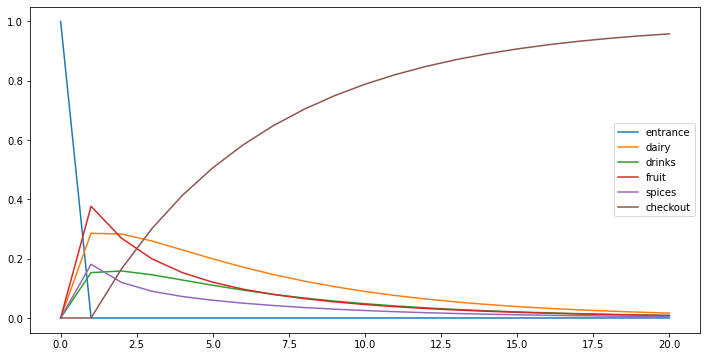

In [25]:
pd.DataFrame(array_plot, columns=['entrance', 'dairy', 'drinks', 'fruit', 'spices', 'checkout']).plot()

In [26]:
john = Customer(name=1, state='entrance', transition_probs=transition_matrix)

while john.state[0] != 'checkout':
    john.next_state()
    print(john)

<Customer 1 is in fruit>
<Customer 1 is in fruit>
<Customer 1 is in fruit>
<Customer 1 is in dairy>
<Customer 1 is in dairy>
<Customer 1 is in fruit>
<Customer 1 is in fruit>
<Customer 1 is in fruit>
<Customer 1 is in fruit>
<Customer 1 is in fruit>
<Customer 1 is in checkout>


In [27]:
class SuperMarket():
    """
    A supermarket which has customers inside.
    """

    def __init__(self):
        customers = []

    
    def __repr__(self):
        return f'<The supermarket has {len(self.customers)} customer/s in it>'

    
    def add_customer(self, new_customer):
        if new_customer in self.customers:
            pass
        else:
            self.customers.append(new_customer)

In [45]:
df['timestamp'][0]
'{:02d}:{:02d}'.format(*divmod(61, 60))


'01:01'